# 5. Export points, plot curves and re-import

## Connect to server and define variables

In [7]:
import GRANTA_MIScriptingToolkit as gdl
from time import strftime
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np

serviceLayer = "http://localhost/mi_servicelayer"
session = gdl.GRANTA_MISession(serviceLayer, autoLogon=True)

'''Specify the target database key, table name, new record name and functional attribute details'''
dbKey = 'MI_Training_10.0.1m'
exportTable = 'Tensile Statistical Data'
importTable = 'Design Data'
newRecordName = 'STK Stats-To-Design Roll-Up Import'
yAxisAttrName = 'Ultimate Tensile Strength'
xAxisAttrName = 'Test Temperature'
mutualAttributeUnit = 'MPa'
funcAttributeName = 'Tens. Ult. Stress (L-dir) with Temp.'
xAxis = ('Temperature', 'Numeric', 'K')  # name, type ('Numeric' OR 'Discrete'), unit (in this order!)

# Table and Subset references
partialExportTableRef = gdl.PartialTableReference(tableName=exportTable)
partialImportTableRef = gdl.PartialTableReference(tableName=importTable)
importTableRef = gdl.TableReference(DBKey=dbKey, name=importTable)
importSubsetReference = gdl.SubsetReference(name=importTable, DBKey=dbKey, partialTableReference=partialImportTableRef)

# Attribute references
funcAttributeRef = gdl.AttributeReference(name=funcAttributeName, DBKey=dbKey,
                                          partialTableReference=partialImportTableRef)
yAxisAttributeRef = gdl.AttributeReference(name=yAxisAttrName, DBKey=dbKey,
                                           partialTableReference=partialExportTableRef)
xAxisAttributeRef = gdl.AttributeReference(name=xAxisAttrName, DBKey=dbKey,
                                           partialTableReference=partialExportTableRef)
expAttributeRefs = [yAxisAttributeRef, xAxisAttributeRef]

## Define the exits search critiria for both our X and Y-Axis attributes

In [8]:
utsExistsSearchVal = gdl.ExistsSearchValue()
utsSearchCriterion = gdl.RecordSearchCriterion(searchAttribute=yAxisAttributeRef,
                         existsSearchValue=utsExistsSearchVal)
tempExistsSearchVal = gdl.ExistsSearchValue()
tempSearchCriterion = gdl.RecordSearchCriterion(searchAttribute=xAxisAttributeRef,
                         existsSearchValue=tempExistsSearchVal)
searchCriteria = gdl.CriteriaSearch(DBKey=dbKey,
                                    searchCriteria=[utsSearchCriterion, tempSearchCriterion])

## Do the search and extract the record references from the response

In [9]:
searchResponse = session.searchService.CriteriaSearch(searchCriteria)
expRecordRefs = [sr.recordReference for sr in searchResponse.searchResults]

## Export the above records and the simple attributes and turn into series

In [11]:
exportRequest = gdl.GetRecordAttributesByRefRequest(recordReferences=expRecordRefs,
                                                    attributeReferences=expAttributeRefs)
exportResponse = session.dataExportService.GetRecordAttributesByRef(exportRequest)
if exportResponse.recordData:
    yValues = [[a.pointDataType.points[0].value for a in r.attributeValues if a.attributeName == yAxisAttrName]
               for r in exportResponse.recordData]
    xValues = [[a.pointDataType.points[0].value for a in r.attributeValues if a.attributeName == xAxisAttrName]
               for r in exportResponse.recordData]
    seriesToImport = pd.DataFrame(list(zip([x[0] for x in xValues], [y[0] for y in yValues])),
                                  columns=[xAxisAttrName, yAxisAttrName])
    sortedDF = seriesToImport.sort_values(by=[xAxisAttrName])
    print(sortedDF)
    additionalSeriesParams = [('Data Type', 'Discrete', 'Test Data')]
else:
    sys.exit('No record data was exported - verify references.')

xData = sortedDF[xAxisAttrName].tolist()
yData = sortedDF[yAxisAttrName].tolist()
series = [(yData, xData, additionalSeriesParams)]

   Test Temperature  Ultimate Tensile Strength
5        194.261276                2399.146240
0        294.261394                2189.890000
4        422.038994                2078.310000
3        588.706055                1848.140015
2        699.817261                1734.376465
1        810.928406                1263.004883


## Calculate 4th order polynomial fit coefficients for series

In [12]:
xDataArr = np.array(xData)
yDataArr = np.array(yData)
coeffs = np.polyfit(xDataArr, yDataArr, 4)

## Define a function for the 4th degree polynomial fit

In [13]:
def My4degPolyFitFunc(x, a, b, c, d, e):

    return a*np.power(x, 4) + b*np.power(x, 3) + c*np.power(x, 2) + d*x + e

## Generate more points in the xRange and use to get the fitted y points

In [14]:
moreXData = np.linspace(min(xData), max(xData), 25)
fittedYData = []
for x in moreXData:
    fittedY = My4degPolyFitFunc(x, coeffs[0], coeffs[1], coeffs[2],
                                coeffs[3], coeffs[4])
    fittedYData.append(fittedY)
series.append((fittedYData, moreXData, [('Data Type', 'Discrete', 'Best Fit Curve')]))

## Plot and show series to be imported

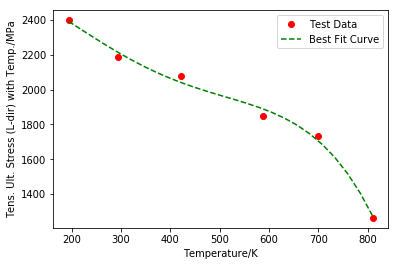

In [25]:
labels = ['Test Data', 'Best Fit Curve']
markers = ['ro', 'g--']
for counter, s in enumerate(series):
    sLabel = ''
    try:
        if s[2]:
            for index, param in enumerate(s[2], 1):
                if index < len(s[2]):
                    labelSubString = param[0] + ' = ' + str(param[2]) + param[3] + ', '
                else:
                    labelSubString = param[0] + ' = ' + str(param[2]) + param[3]
                sLabel = sLabel + labelSubString
        else:
            sLabel = labels[counter]
    except IndexError:
        sLabel = labels[counter]
    plt.plot(s[1], s[0], markers[counter], label=sLabel)

plt.legend(loc='upper right')
plt.ylabel(funcAttributeName + r'/' + mutualAttributeUnit)
if xAxis[1] == 'Numeric':
    plt.xlabel(xAxis[0] + r'/' + xAxis[2])
elif xAxis[1] == 'Discrete':
    plt.xlabel(xAxis[0])
else:
    sys.exit('Incorrect or unspecified type for x-Axis parameter')
plt.show()

## Get the root node of the table to import to (we won't create any folders in this example)

In [26]:
RootNodeRequest = gdl.GetRootNode(table=importTableRef)
myRootNodeRef = session.browseService.GetRootNode(RootNodeRequest).rootNode.recordReference

## Function to create the xyPoints list

In [27]:
def CreateXYPoints(yValues, xValues, xAxisType):
    
    xyPoints = []
    for index, y in enumerate(yValues,0):
        if xAxisType == 'Numeric':
            paramValue = gdl.ParameterValue(numericValue=float(xValues[index]))
        elif xAxisType == 'Discrete':
            paramValue = gdl.ParameterValue(discreteValue=xValues[index])
        else:
            sys.exit('Incorrect or unspecified type for x-Axis parameter')
        xyPoints.append(gdl.XYPoint(Y=float(y), parameterValue=paramValue))
        
    return xyPoints

## Function to create the Constraints list

In [28]:
def CreateConstraints(additionalSeriesParams, dbKey):
    
    constraints = []
    for param in additionalSeriesParams:
        if param[1] == 'Numeric':
            paramValue = gdl.ParameterValue(numericValue=float(param[2]))
        elif param[1] == 'Discrete':
            paramValue = gdl.ParameterValue(discreteValue=param[2])
        else:
            sys.exit('Incorrect or unspecified parameter type for additional parameter "{}"'.format(param[0]))
        paramRef = gdl.ParameterReference(name=param[0], DBKey=dbKey)
        constraints.append(gdl.Constraint(parameterValue=paramValue, parameter=paramRef))
        
    return constraints

## Function to create the X-Axis information object

In [29]:
def CreateXAxisInfo(xAxis, dbKey):
    
    paramRef = gdl.ParameterReference(name=xAxis[0], DBKey=dbKey)
    if xAxis[1] == 'Numeric':
        unitInfo = gdl.UnitInformation(unitSymbol=xAxis[2])
        paramInfo = gdl.ParameterInformation(parameterReference=paramRef, name=xAxis[0], unit=unitInfo)
    else:
        paramInfo = gdl.ParameterInformation(parameterReference=paramRef, name=xAxis[0])
    
    return paramInfo

## Function to create the Parameters list

In [30]:
def CreateParameters(additionalSeriesParams, dbKey):
    
    params = []
    for param in additionalSeriesParams:
        paramRef = gdl.ParameterReference(name=param[0], DBKey=dbKey)
        if param[1] == 'Numeric':
            unitInfo = gdl.UnitInformation(unitSymbol=param[3])
            paramInfo = gdl.ParameterInformation(parameterReference=paramRef, name=param[0], unit=unitInfo)
        else:
            paramInfo = gdl.ParameterInformation(parameterReference=paramRef, name=param[0])
        params.append(paramInfo)
        
    return params

## Generate the functional attribute import object

This cell does all the hard work of calling the above functions to build up the nested series functional attribute import object

In [31]:
seriesObjects = []
decors = [1, 0]
for index, s in enumerate(series):
    xyData = gdl.XYData(XYPoints=CreateXYPoints(s[0], s[1], xAxis[1]))
    newConstraints = gdl.Constraints(constraints=CreateConstraints(s[2], dbKey))
    seriesObjects.append(gdl.Series(XYPoints=xyData, decoration=decors[index], constraints=newConstraints))
    
newGraph = gdl.FloatFunctionalSeriesGraph(series=seriesObjects, XAxisParameter=CreateXAxisInfo(xAxis, dbKey))
paramRefs = gdl.Parameters(parameters=CreateParameters(series[0][2], dbKey))
yAxisUnitInfo = gdl.UnitInformation(unitSymbol=mutualAttributeUnit)
seriesFunctionalObject = gdl.FloatFunctionalSeriesDataType(graph=newGraph, parameters=paramRefs,
                                                           unitInformation=yAxisUnitInfo)
funcAttributeImportObject = gdl.ImportAttributeValue(attributeReference=funcAttributeRef,
                                                     floatFunctionalSeriesDataType=seriesFunctionalObject)

## Import the new record and functional attribute

In [32]:
recNameWithTime = newRecordName + ' - ' + strftime("%Y-%m-%d %H:%M:%S")

myImportRecord = gdl.ImportRecord(recordName = recNameWithTime, isFolder = False,
                                  importAttributeValues = [funcAttributeImportObject],
                                  importRecordMode = 'Create', subsetReferences = [importSubsetReference],
                                  existingRecord = myRootNodeRef,
                                  releaseRecord = False)

setRecordAttributesRequest = gdl.SetRecordAttributesRequest(importRecords=[myImportRecord])
setRecordAttributesResponse = session.dataImportService.SetRecordAttributes(setRecordAttributesRequest)

for record in setRecordAttributesResponse.recordsImported:
    print('Imported record {}s to GRANTA MI database'.format(record.shortName))

Imported record STK Stats-To-Design Roll-Up Import - 2018-01-17 19:56:31s to GRANTA MI database
